# Part 3 Task 1
https://github.com/josStorer/RWKV-Runner/blob/master/README_ZH.md

# 正式开始构建这个Pipeline

## 设置路径

In [138]:
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# TODO: Set Your Own Dir toward the "DSGA1011 NLP Final Project"
base_dir = os.path.join('/content/drive', 'MyDrive', 'DSGA1011 NLP Final Project')
base_dir

'/content/drive/MyDrive/DSGA1011 NLP Final Project'

In [ ]:
os.path.exists(base_dir)

True

In [ ]:
# the working dir
working_dir = os.path.join(base_dir, 'RWKV API processing')

# Check whether the file exist, if not, raise error
if not os.path.exists(working_dir):
  raise Exception('The working dir does not exist')
else:
  # Print the file under it
  sub_files = os.listdir(working_dir)
  # add /n to subfiles
  sub_files = "\n".join(sub_files)
  file_info = f"The existing files under {working_dir} are: \n{sub_files}"
  print(file_info)

The existing files under /content/drive/MyDrive/DSGA1011 NLP Final Project/RWKV API processing are: 
Copy of Tryrunner_for_RACE.ipynb
models
RWKV-Runner
data
outputs
rwkv_env
requirements.txt
Layerwise Visualization.ipynb
RWKV 模型加载.py
层级激活提取与分析.py
Token 级归因分析.py
端到端管道与 RWKV 集成.py
Download_g1.ipynb
server.log
api.log.2 (1)
api.log.1 (1)
api.log
Tryrunner_hidden.ipynb
api.log.3
Tryrunner_for_RACE.ipynb
api.log.1
api.log.2


In [ ]:
# Set to working dir
os.chdir(working_dir)

In [ ]:
!ls

 api.log			     outputs
 api.log.1			     requirements.txt
'api.log.1 (1)'			     rwkv_env
 api.log.2			     RWKV-Runner
'api.log.2 (1)'			    'RWKV 模型加载.py'
 api.log.3			     server.log
'Copy of Tryrunner_for_RACE.ipynb'  'Token 级归因分析.py'
 data				     Tryrunner_for_RACE.ipynb
 Download_g1.ipynb		     Tryrunner_hidden.ipynb
'Layerwise Visualization.ipynb'      层级激活提取与分析.py
 models				    '端到端管道与 RWKV 集成.py'


## Initalize and test

In [ ]:
# 重设python环境（请选择1）
!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!update-alternatives --config python3

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
  0            /usr/bin/python3.12   2         auto mode
* 1            /usr/bin/python3.10   1         manual mode
  2            /usr/bin/python3.12   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1


In [ ]:
# 重新安装pip
!curl -sS https://bootstrap.pypa.io/get-pip.py | python3

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.3
    Uninstalling pip-25.3:
      Successfully uninstalled pip-25.3


In [ ]:
!/usr/bin/python3.10 -m pip install -r RWKV-Runner/backend-python/requirements.txt

In [ ]:
!/usr/bin/python3.10 -m pip install ninja

In [141]:
# Star url
!fuser -k 8000/tcp || true
!/usr/bin/python3.10 RWKV-Runner/backend-python/main.py --host 0.0.0.0 --port 8000 > server.log 2>&1 &
# !/usr/bin/python3.10 RWKV-Runner/backend-python/main.py --host 0.0.0.0 --port 8000 2>&1 | tee server.log

In [ ]:
# API doc
from google.colab import output
docs_url = output.eval_js("google.colab.kernel.proxyPort(8000)") + "/docs"
print("Docs URL:", docs_url)


Docs URL: https://8000-gpu-t4-hm-1sys3n8nnjvdt-c.europe-west4-1.prod.colab.dev/docs


In [ ]:
# # Enable cache
import requests
!/usr/bin/python3.10 -m pip install cyac==1.9
cache_enable_resp = requests.post("http://127.0.0.1:8000/enable-state-cache")
print(cache_enable_resp.status_code, cache_enable_resp.text)
# 200 "success"

200 "success"


In [ ]:
# Import
import requests
import json
import time
import re
from tqdm import tqdm

In [ ]:
# Test
switch_body = {
    "model": "models/RWKV-x070-World-0.1B-v2.8-20241210-ctx4096.pth",
    "strategy": "cuda fp16",
    "tokenizer": "",
    "customCuda": True,
    "deploy": False
}
r = requests.post("http://127.0.0.1:8000/switch-model", json=switch_body)
print(r.status_code, r.text)
# 200 "success"

200 "success"


## 模型下载

In [ ]:
!pip install -q huggingface_hub

In [ ]:
import os
import shutil
from huggingface_hub import hf_hub_download

# ===========================================================
# 1. 统一配置：模型展示名称 → { filename, repo_id }
#    统一下载到 /content/models
# ===========================================================

MODEL_BASE_DIR = "/content/models"

MODEL_SOURCES = {
    # --- World series ---
    "World 0.1B": {
        "filename": "RWKV-x070-World-0.1B-v2.8-20241210-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-world",
    },
    "World 0.4B": {
        "filename": "RWKV-x070-World-0.4B-v2.9-20250107-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-world",
    },
    "World 1.5B": {
        "filename": "RWKV-x070-World-1.5B-v3-20250127-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-world",
    },
    "World 2.9B": {
        "filename": "RWKV-x070-World-2.9B-v3-20250211-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-world",
    },

    # --- Pile series ---
    "Pile 1.47B": {
        "filename": "RWKV-x070-Pile-1.47B-20241210-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },
    "Pile 421M": {
        "filename": "RWKV-x070-Pile-421M-20241127-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },
    "Pile 168M": {
        "filename": "RWKV-x070-Pile-168M-20241120-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },
    "Pile 165M L25-D576": {
        "filename": "RWKV-x070-Pile-165M-L25-D576-20241218-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },
    "Pile 164M L33-D512": {
        "filename": "RWKV-x070-Pile-164M-L33-D512-20241218-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv-7-pile",
    },

    # --- g1 series（注意 repo_id 和 2.9B 的日期） ---
    "g1 0.1B": {
        "filename": "rwkv7-g1-0.1b-20250307-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv7-g1",
    },
    "g1 0.4B": {
        "filename": "rwkv7-g1-0.4b-20250324-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv7-g1",
    },
    "g1 1.5B": {
        "filename": "rwkv7-g1-1.5b-20250429-ctx4096.pth",
        "repo_id": "BlinkDL/rwkv7-g1",
    },
    "g1 2.9B": {
        "filename": "rwkv7-g1-2.9b-20250519-ctx4096.pth",  # ← 这里用 19
        "repo_id": "BlinkDL/rwkv7-g1",
    },
}


# ===========================================================
# 2. 用 hf_hub_download 下载单个模型
# ===========================================================

def download_model(repo_id: str, filename: str, local_path: str) -> bool:
    """
    Download a model file via hf_hub_download, then copy
    from HF 缓存到 local_path（/content/models/...）。

    Return True if success, False otherwise.
    """
    try:
        os.makedirs(os.path.dirname(local_path), exist_ok=True)

        print(f"[INFO] Downloading {filename} from {repo_id} via hf_hub_download ...")
        # 这一步会：
        # - 处理权限 / token
        # - 自动断点续传
        # - 用自己的 tqdm 显示下载进度
        downloaded_path = hf_hub_download(
            repo_id=repo_id,
            filename=filename,
            repo_type="model",
        )

        # 如果缓存路径和目标路径不同，就拷贝一份
        if downloaded_path != local_path:
            shutil.copy2(downloaded_path, local_path)

        print(f"[OK] Saved to {local_path}\n")
        return True

    except Exception as e:
        print(f"[ERROR] Failed to download {filename} from {repo_id}: {e}\n")
        # 出错时尽量删掉半截文件
        try:
            if os.path.exists(local_path):
                os.remove(local_path)
        except Exception:
            pass
        return False


# ===========================================================
# 3. 主入口：根据 selected_models 构建最终 model_dict
# ===========================================================

def prepare_model_dict(selected_models, base_dir: str = MODEL_BASE_DIR):
    """
    Build a model_dict for selected models using hf_hub_download.

    规则：
    1. 只处理 selected_models 里指定的模型；
    2. 如果 /content/models 下已有对应文件，直接复用；
    3. 如果本地没有，就用 hf_hub_download 下载；
    4. 下载失败则跳过，并且不写入字典。
    """
    os.makedirs(base_dir, exist_ok=True)
    model_dict = {}

    for name in selected_models:
        if name not in MODEL_SOURCES:
            print(f"[WARN] Unknown model name: {name}, skipped.")
            continue

        info = MODEL_SOURCES[name]
        filename = info["filename"]
        repo_id = info["repo_id"]
        local_path = os.path.join(base_dir, filename)

        # 1) 已经下载过？
        if os.path.exists(local_path):
            print(f"[OK] Found local model: {name} -> {local_path}")
            model_dict[name] = local_path
            continue

        # 2) 没有就下载
        ok = download_model(repo_id, filename, local_path)

        # 3) 下载成功才写入字典
        if ok and os.path.exists(local_path):
            model_dict[name] = local_path
        else:
            print(f"[ERROR] {name} download failed, not added to model_dict.\n")

    return model_dict

In [ ]:
# # ===== 只选 World 系列 =====

selected_models = [
    name for name in MODEL_SOURCES.keys()
    if name.startswith("World ") or name.startswith("g1 ")
]

model_dict = prepare_model_dict(selected_models)

print("Final model_dict:", model_dict)

[OK] Found local model: World 0.1B -> /content/models/RWKV-x070-World-0.1B-v2.8-20241210-ctx4096.pth
[OK] Found local model: World 0.4B -> /content/models/RWKV-x070-World-0.4B-v2.9-20250107-ctx4096.pth
[OK] Found local model: World 1.5B -> /content/models/RWKV-x070-World-1.5B-v3-20250127-ctx4096.pth
[OK] Found local model: World 2.9B -> /content/models/RWKV-x070-World-2.9B-v3-20250211-ctx4096.pth
[OK] Found local model: g1 0.1B -> /content/models/rwkv7-g1-0.1b-20250307-ctx4096.pth
[OK] Found local model: g1 0.4B -> /content/models/rwkv7-g1-0.4b-20250324-ctx4096.pth
[OK] Found local model: g1 1.5B -> /content/models/rwkv7-g1-1.5b-20250429-ctx4096.pth
[OK] Found local model: g1 2.9B -> /content/models/rwkv7-g1-2.9b-20250519-ctx4096.pth
Final model_dict: {'World 0.1B': '/content/models/RWKV-x070-World-0.1B-v2.8-20241210-ctx4096.pth', 'World 0.4B': '/content/models/RWKV-x070-World-0.4B-v2.9-20250107-ctx4096.pth', 'World 1.5B': '/content/models/RWKV-x070-World-1.5B-v3-20250127-ctx4096.pth',

## Basic Functions for model

In [ ]:
def bulid_chat_body(
  content_list: list,
  model="rwkv",
  max_tokens=128,
  temperature=0.3
    ):

  chat_body = {
    "model": model,
    "messages": [
      {
        "role": "user",
        "content":"\n\n".join(content_list),
        "raw": False
      }
    ],
    "stream": False,
    "max_tokens": max_tokens,
    "temperature": temperature
  }
  return chat_body

def parse_choice_letter(text: str):
  if not text: return None
  split_str = text.strip().splitlines()
  if not split_str: return None
  first = split_str[0]
  m = re.search(r"\b([ABCD])\b", first, flags=re.I)
  return m.group(1).upper() if m else None

# def get_response(chat_body, chat_mode = "chat/completions"):
#   r = requests.post(f"http://127.0.0.1:8000/{chat_mode}", json=chat_body)
#   return r.json()["choices"][0]["message"]["content"]

def switch_model(version="World 0.1B"):
  model_path = model_dict[version]

  swich_body = {
    "model": model_path,
    "strategy": "cuda fp16",
    "tokenizer": "",
    "customCuda": True,
    "deploy": False
  }

  r = requests.post("http://127.0.0.1:8000/switch-model", json=swich_body)
  if r.status_code != 200:
    print(f"[switch_model] Warning: failed to switch model: {r.text}")
  else:
    print(f"Success: switched to {version}")
    # print(json.dumps(r.json(), indent=2))
  # 200 "success"

## QuALITY Dataset

In [ ]:
dev_QuALITY_path = os.path.join("data", "QuALITY",'QuALITY.v1.0.1.htmlstripped.dev')

In [ ]:
import json
import os

dev_QuALITY_path = os.path.join("data", "QuALITY", "QuALITY.v1.0.1.htmlstripped.dev")

quality_dev = []

with open(dev_QuALITY_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            quality_dev.append(json.loads(line))


In [ ]:
# For QuALITY dataset: difficulty ∈ {"difficult", "normal"}
def get_question_difficulty(qobj):
    # qobj 是单独的一个 question dict
    d = qobj.get("difficult", None)
    if d == 0:
        return "normal"
    elif d == 1:
        return "difficult"
    else:
        return "unknown"



In [ ]:
from collections import Counter

diffs = []

for samp in quality_dev:
    for q in samp["questions"]:
        diffs.append(get_question_difficulty(q))

Counter(diffs)

Counter({'normal': 1021, 'difficult': 1065})

## QuALITY数据辅助函数

In [ ]:
def get_question_str(qobj):
    """
    qobj 是 samp["questions"][i]
    """
    question = qobj["question"]
    opts = qobj["options"]

    return "\n".join([
        "Question:",
        question,
        "\nOptions:",
        f"A: {opts[0]}",
        f"B: {opts[1]}",
        f"C: {opts[2]}",
        f"D: {opts[3]}",
    ])


In [ ]:
sample = quality_dev[0]
qobj = sample["questions"][0]   # 第一条 question

print(get_question_str(qobj))


Question:
How much time has passed between Blake's night with Eldoria and his search for Sabrina York in his mind-world?

Options:
A: 7 years
B: 10 hours
C: 12 years
D: 1 hour


## 单个问题测试（跑通了再走下一步）

In [ ]:
# switch model
model_name = list(model_dict.keys())[5]
switch_model(model_name)

Success: switched to g1 0.4B


In [ ]:
# 0. 载入你自己的 dev 文件 quality_dev = [...]

###############################################
# 1. flatten QuALITY (关键)
###############################################

def flatten_quality(dev_set):
    idx2letter = {1:"A", 2:"B", 3:"C", 4:"D"}  # ★ 你的 gold_label 是 1–4

    flat = []
    for art in dev_set:
        article_text = art["article"]
        for q in art["questions"]:
            flat.append({
                "article": article_text,
                "question": q["question"],
                "options": q["options"],
                "answer": idx2letter[q["gold_label"]],        # ★ 数字 → 字母
                "question_unique_id": q["question_unique_id"],
                "difficulty": "difficult" if q["difficult"] == 1 else "normal"
            })
    return flat

flat_quality_dev = flatten_quality(quality_dev)


###############################################
# 2. Formatting question string (不变)
###############################################
def get_question_str(qobj):
    opts = qobj["options"]
    return "\n".join([
        "Question:",
        qobj["question"],
        "\nOptions:",
        f"A: {opts[0]}",
        f"B: {opts[1]}",
        f"C: {opts[2]}",
        f"D: {opts[3]}",
    ])


###############################################
# 3. Few-shot formatting (same as RACE)
###############################################
def build_few_shot_examples(samples):
    blocks = []
    for i, s in enumerate(samples):
        block = (
            f"--- EXAMPLE {i+1} (DO NOT ANSWER) START ---\n"
            "Passage:\n"
            f"{s['article']}\n\n"
            f"{get_question_str(s)}\n\n"
            f"Correct Answer: {s['answer']}\n"       # ★已经是字母
            f"--- EXAMPLE {i+1} END ---\n\n"
        )
        blocks.append(block)
    return "### FEW-SHOT EXAMPLES (DO NOT ANSWER) ###\n\n" + "".join(blocks)


###############################################
# 4. Pick few-shot + test examples (不变)
###############################################
num_few_shots = 3
few_shot_samples = flat_quality_dev[:num_few_shots]
test_samp = flat_quality_dev[num_few_shots + 1]


###############################################
# 5. Build final prompt (不变)
###############################################
rule_setting = (
    "You are answering a multiple-choice reading comprehension question.\n"
    "First you will see several solved examples. DO NOT answer them.\n"
    "Only answer the final question labeled '### REAL QUESTION — ANSWER THIS ONLY ###'.\n"
    "Return ONLY one letter from {A,B,C,D}.\n"
    "Output ONLY the letter on the FIRST line.\n"
    "Do NOT output any explanation.\n"
    "Do NOT repeat the passage or options.\n"
    "Do NOT add ANY extra text.\n"
)

few_shot_block = build_few_shot_examples(few_shot_samples)

cur_question = (
    "### REAL QUESTION — ANSWER THIS ONLY ###\n"
    "Passage:\n"
    f"{test_samp['article']}\n\n"
    f"{get_question_str(test_samp)}\n"
)

content_list = [rule_setting, few_shot_block, cur_question, "Your Answer:"]


###############################################
# 6. Send to RWKV chat server (只改 print 部分)
###############################################
chat_body = bulid_chat_body(content_list, temperature=0.0, max_tokens=50)

r = requests.post("http://127.0.0.1:8000/chat/completions", json=chat_body)
raw_output = r.json()
mode_answer = raw_output["choices"][0]["message"]["content"]
gold_answer = test_samp["answer"]   # ★已经是字母了

print(f"Raw Output: {json.dumps(raw_output, indent=2, ensure_ascii=False)}")
print(f"PRED: {parse_choice_letter(mode_answer)}, GOLD: {gold_answer}")


Raw Output: {
  "object": "chat.completion",
  "model": "rwkv7-g1-0.4b-20250324-ctx4096",
  "choices": [
    {
      "message": {
        "role": "assistant",
        "content": "\nA: a criminal that Blake is hunting"
      },
      "index": 0,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 28142,
    "completion_tokens": 9,
    "total_tokens": 28151
  }
}
PRED: A, GOLD: A


In [142]:
!pip install subprocess

ERROR: Could not find a version that satisfies the requirement subprocess (from versions: none)
ERROR: No matching distribution found for subprocess


## 遍历所有内容（上一步跑通了再这一步）

In [143]:
import os
import json
import time
import subprocess
import requests
from tqdm.notebook import tqdm

############################################################
# 0. 自动重启 RWKV server 的封装（等价于你那两行 ! 命令）
############################################################

def restart_server():
    """
    等价于：
      !fuser -k 8000/tcp || true
      !/usr/bin/python3.10 RWKV-Runner/backend-python/main.py --host 0.0.0.0 --port 8000 > server.log 2>&1 &
    用 Python 实现一遍，方便在脚本内部调用。
    """
    print("[server] 🔄 Restarting RWKV server on port 8000 ...")

    # 1) 先杀掉占用 8000 端口的进程（如果没有就算了）
    try:
        subprocess.run(["fuser", "-k", "8000/tcp"], check=False)
    except FileNotFoundError:
        print("[server] ⚠️ fuser not found, skip killing port")

    # 2) 再以后台进程的方式启动新的 server
    log_file = open("server.log", "ab")  # 追加写入日志
    subprocess.Popen(
        [
            "/usr/bin/python3.10",
            "RWKV-Runner/backend-python/main.py",
            "--host", "0.0.0.0",
            "--port", "8000",
        ],
        stdout=log_file,
        stderr=subprocess.STDOUT,
    )
    # 给它一点时间加载模型
    print("[server] ✅ New server process started, waiting 10s for warmup...")
    time.sleep(10.0)


############################################################
# 1. 对 /chat/completions 做一个「带重试 + 自动重启」的封装
############################################################

def robust_chat_completion(
    ask_body,
    url="http://127.0.0.1:8000/chat/completions",
    max_retries=5,
    base_delay=5.0,
    timeout=60,
    auto_restart=True,
):
    """
    - 网络错误 / 连接拒绝 / status!=200 都会重试
    - 第一次失败时，如果 auto_restart=True，会调用 restart_server() 拉起新 server
    - 之后采用线性退避：sleep = base_delay * attempt
    - 超过 max_retries 之后返回 None，由上层记为失败样本
    """
    for attempt in range(1, max_retries + 1):
        try:
            resp = requests.post(
                url,
                json=ask_body,
                timeout=timeout,
            )
        except requests.exceptions.RequestException as e:
            print(f"[chat][{attempt}/{max_retries}] RequestException: {e}")
            # 第一次失败时尝试重启 server
            if auto_restart and attempt == 1:
                print("[chat] Trying to restart server...")
                restart_server()
        else:
            # 请求发出成功，检查 HTTP 状态码
            if resp.status_code == 200:
                return resp
            else:
                preview = resp.text[:200].replace("\n", " ")
                print(f"[chat][{attempt}/{max_retries}] "
                      f"Bad status {resp.status_code}, body preview: {preview}")
                if auto_restart and attempt == 1:
                    print("[chat] Bad status on first attempt, restarting server...")
                    restart_server()

        # 本次失败，准备下一轮重试
        if attempt < max_retries:
            sleep_t = base_delay * attempt
            print(f"[chat] Retry in {sleep_t:.1f}s ...")
            time.sleep(sleep_t)

    print("[chat] ❌ Exceeded max_retries, give up this sample.")
    return None


############################################################
# 2. 读 QuALITY dev
############################################################

dev_QuALITY_path = os.path.join("data", "QuALITY", "QuALITY.v1.0.1.htmlstripped.dev")

quality_dev = []
with open(dev_QuALITY_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            quality_dev.append(json.loads(line))

print(f"Loaded raw QuALITY dev articles = {len(quality_dev)}")


############################################################
# 3. flatten QuALITY：文章 → 每个问题一条样本
############################################################

def flatten_quality(dev_set):
    # gold_label ∈ {1,2,3,4} → 字母
    idx2letter = {1: "A", 2: "B", 3: "C", 4: "D"}
    flat = []
    for art in dev_set:
        article_text = art["article"]
        for q in art["questions"]:
            flat.append({
                "article": article_text,
                "question": q["question"],
                "options": q["options"],
                "answer": idx2letter[q["gold_label"]],
                "question_unique_id": q["question_unique_id"],
                "difficulty": "difficult" if q["difficult"] == 1 else "normal",
            })
    return flat

flat_quality_dev = flatten_quality(quality_dev)
print(f"Flattened QuALITY dev questions = {len(flat_quality_dev)}")


############################################################
# 4. 问题转成字符串（沿用你自己的格式）
############################################################

def get_question_str(qobj):
    question = qobj["question"]
    opts = qobj["options"]
    return "\n".join([
        "Question:",
        question,
        "\nOptions:",
        f"A: {opts[0]}",
        f"B: {opts[1]}",
        f"C: {opts[2]}",
        f"D: {opts[3]}",
    ])


############################################################
# 5. Few-shot 示例（按 RACE 逻辑，但截断 passage）
############################################################

MAX_FEWSHOT_CHARS = 1000   # few-shot 里的 passage 截断长度
MAX_ARTICLE_CHARS = 1500   # 当前问题的 passage 截断长度，防止太长

def build_few_shot_examples(samples):
    blocks = []
    header = "### FEW-SHOT EXAMPLES (DO NOT ANSWER) ###\n\n"

    for i, s in enumerate(samples):
        truncated_article = s["article"][:MAX_FEWSHOT_CHARS]
        block = (
            f"--- EXAMPLE {i+1} (DO NOT ANSWER) START ---\n"
            "Passage:\n"
            f"{truncated_article}\n\n"
            f"{get_question_str(s)}\n\n"
            f"Correct Answer: {s['answer']}\n"
            f"--- EXAMPLE {i+1} END ---\n\n"
        )
        blocks.append(block)

    return header + "".join(blocks)


############################################################
# 6. Global prompt settings（沿用 RACE 版本）
############################################################

rule_setting = (
    "You are answering a multiple-choice reading comprehension question.\n"
    "First you will see several solved examples. DO NOT answer them.\n"
    "Only answer the final question labeled '### REAL QUESTION — ANSWER THIS ONLY ###'.\n"
    "Return ONLY one letter from {A,B,C,D}.\n"
    "Output ONLY the letter on the FIRST line.\n"
    "Do NOT output any explanation.\n"
    "Do NOT repeat the passage or options.\n"
    "Do NOT add ANY extra text.\n"
)


############################################################
# 7. Config：few-shots / debug / 输出目录
############################################################

num_few_shots = 3

few_shot_samples = flat_quality_dev[:num_few_shots]
few_shot_block = build_few_shot_examples(few_shot_samples)

eval_samples = flat_quality_dev
total_len = len(eval_samples)

debug = False
debug_max_samples = 50
if debug:
    total_len = min(total_len, debug_max_samples)
    eval_samples = eval_samples[:total_len]

print(f"Evaluating on QuALITY dev, total samples = {total_len}")

output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)


############################################################
# 8. Loop over models（使用 robust_chat_completion）
############################################################

Test_models = model_dict.keys()
result_summary = {}

for cur_model in Test_models:
    print(f"\n========== Evaluating model: {cur_model} ==========")

    # 切换模型（你自己已有实现）
    switch_model(cur_model)

    acc_list = []
    diff_acc_list = []    # difficult
    norm_acc_list = []    # normal

    per_question_records = []

    start_time = time.time()
    pbar = tqdm(total=total_len)

    for idx, samp in enumerate(eval_samples):
        article = samp["article"][:MAX_ARTICLE_CHARS]
        q_str = get_question_str(samp)
        gold_answer = samp["answer"]
        difficulty = samp["difficulty"]
        qid = samp["question_unique_id"]

        cur_question_block = (
            "### REAL QUESTION — ANSWER THIS ONLY ###\n"
            "Passage:\n"
            f"{article}\n\n"
            f"{q_str}\n"
        )

        end_node = "Your Answer:"

        content_list = [rule_setting, few_shot_block, cur_question_block, end_node]

        ask_body = bulid_chat_body(
            content_list,
            max_tokens=5,
            temperature=0.0
        )

        # ⭐ 用带重试 + 自动重启 的接口
        resp = robust_chat_completion(ask_body)

        if (resp is None) or (resp.status_code != 200):
            raw_output = None
            pred_choice = None
        else:
            raw_output = resp.json()["choices"][0]["message"]["content"]
            pred_choice = parse_choice_letter(raw_output)

        correct = int(pred_choice == gold_answer) if pred_choice is not None else 0

        acc_list.append(correct)
        if difficulty == "difficult":
            diff_acc_list.append(correct)
        elif difficulty == "normal":
            norm_acc_list.append(correct)

        per_question_records.append({
            "question_unique_id": qid,
            "index_in_split": idx,
            "difficulty": difficulty,
            "gold": gold_answer,
            "pred": pred_choice,
            "correct": correct,
            "raw_output": raw_output,
        })

        cur_acc = sum(acc_list) / len(acc_list) if acc_list else 0.0
        cur_diff = sum(diff_acc_list) / len(diff_acc_list) if diff_acc_list else 0.0
        cur_norm = sum(norm_acc_list) / len(norm_acc_list) if norm_acc_list else 0.0

        pbar.set_postfix_str(
            f"{cur_model}-[{idx+1}/{total_len}] "
            f"Acc(Overall/Difficult/Normal): "
            f"{cur_acc:.4f}/{cur_diff:.4f}/{cur_norm:.4f}"
        )
        pbar.update(1)

    pbar.close()
    end_time = time.time()
    duration = end_time - start_time

    final_acc = sum(acc_list) / len(acc_list) if acc_list else 0.0
    final_diff = sum(diff_acc_list) / len(diff_acc_list) if diff_acc_list else 0.0
    final_norm = sum(norm_acc_list) / len(norm_acc_list) if norm_acc_list else 0.0

    print(f"{cur_model} - Total time: {duration:.2f}s")
    print(
        f"{cur_model} - Final Acc(Overall/Difficult/Normal): "
        f"{final_acc:.4f}/{final_diff:.4f}/{final_norm:.4f}"
    )

    result_summary[cur_model] = {
        "Total time": duration,
        "Overall Accuracy": final_acc,
        "Difficult Accuracy": final_diff,
        "Normal Accuracy": final_norm,
        "Num samples": total_len,
        "Num few-shots": num_few_shots,
    }

    per_model_path = os.path.join(
        output_dir,
        f"QuALITY_dev_per_question_{cur_model}.jsonl"
    )
    with open(per_model_path, "w", encoding="utf-8") as f:
        for rec in per_question_records:
            f.write(json.dumps(rec, ensure_ascii=False) + "\n")
    print(f"Per-question results saved to: {per_model_path}")


############################################################
# 9. 保存所有模型的 summary
############################################################

summary_path = os.path.join(output_dir, "QuALITY_dev_summary.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(result_summary, f, indent=2, ensure_ascii=False)

print(f"\nAll model summaries saved to: {summary_path}")


Loaded raw QuALITY dev articles = 230
Flattened QuALITY dev questions = 2086
Evaluating on QuALITY dev, total samples = 2086

========== Evaluating model: World 0.1B ==========
Success: switched to World 0.1B


  0%|          | 0/2086 [00:00<?, ?it/s]

 24%|██▎       | 492/2086 [06:13<20:10,  1.32it/s, World 0.1B-[492/2086] Acc(Overall/Difficult/Normal): 0.0346/0.0291/0.0437]


[chat][1/5] RequestException: HTTPConnectionPool(host='127.0.0.1', port=8000): Read timed out. (read timeout=60)
[chat] Trying to restart server...
[server] 🔄 Restarting RWKV server on port 8000 ...
[server] ✅ New server process started, waiting 10s for warmup...
[chat] Retry in 5.0s ...
[chat][2/5] RequestException: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /chat/completions (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7a7bac2695b0>: Failed to establish a new connection: [Errno 111] Connection refused'))
[chat] Retry in 10.0s ...
[chat][3/5] RequestException: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /chat/completions (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7a7bac3f8ec0>: Failed to establish a new connection: [Errno 111] Connection refused'))
[chat] Retry in 15.0s ...
[chat][4/5] RequestException: HTTPConnectionPool(host='127.0.0.1', port=8

KeyboardInterrupt: 

# RACE Dataset


## 加载和分析RACE数据集

In [ ]:
!pip install -q datasets

from datasets import load_dataset

# 所有数据
race_all = load_dataset("ehovy/race", "all")

README.md: 0.00B [00:00, ?B/s]

all/test-00000-of-00001.parquet:   0%|          | 0.00/2.08M [00:00<?, ?B/s]

all/train-00000-of-00001.parquet:   0%|          | 0.00/37.4M [00:00<?, ?B/s]

all/validation-00000-of-00001.parquet:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4934 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/87866 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4887 [00:00<?, ? examples/s]

In [ ]:
print(f"example_number_of_all_validation: {len(race_all['validation'])}")
print(f"keys of race data sample:{race_all["train"][0].keys()}")
print(f"Answer example: {race_all["train"][0]['answer']}")


example_number_of_all_validation: 4887
keys of race data sample:dict_keys(['example_id', 'article', 'answer', 'question', 'options'])
Answer example: C


In [ ]:
article_text = race_all["train"][0]['article']
words = article_text.split()
word_count = len(words)
print(f"The article has {word_count} words.")

The article has 327 words.


## Race数据集辅助函数

In [ ]:
# 测试是否我们总是能从'example_id'获得middle或者high

def get_difficulty(samp):
  example_id = samp["example_id"]
  is_high = False
  is_middle = False
  if "high" in example_id:
    is_high = True
  if "middle" in example_id:
    is_middle = True

  if is_high and is_middle:
    raise ValueError(f"example_id {example_id} is both high and middle")
  elif (not is_high) and (not is_middle):
    raise ValueError(f"example_id {example_id} is neither high nor middle")
  elif is_high:
    return "high"
  elif is_middle:
    return "middle"
  else:
    raise ValueError("Something went wrong with the process of '[get_difficulty]'")

# for split in ["train", "validation", "test"]:
#   for samp in tqdm(race_all[split]):
#     if get_difficulty(samp) in ["high", "middle"]:
#       pass
#     else:
#       raise ValueError(f"Unkown difficulty {get_difficulty(samp)}")


100%|██████████| 4934/4934 [00:00<00:00, 17595.06it/s]


## RACE数据辅助函数

In [ ]:
def get_question_str(samp):
  question = samp["question"]
  opts = samp["options"]
  return "\n".join([
      "Question:",
      question,
      "\nOptions:",
      f"A: {opts[0]}",
      f"B: {opts[1]}",
      f"C: {opts[2]}",
      f"D: {opts[3]}",
  ])

## 单个问题测试（跑通了再走下一步）

In [ ]:
# switch model
model_name = list(model_dict.keys())[5]
switch_model(model_name)

Success: switched to g1 0.4B


In [ ]:
# Prompt test

import requests  # if not already imported

# How many few-shot examples you want to use
num_few_shots = 3  # you can change this number

# Select few-shot samples and one test sample
few_shot_indices = list(range(num_few_shots))  # e.g. [0, 1, 2]
few_shot_samples = [race_all["train"][i] for i in few_shot_indices]

# Make sure this index is not inside few_shot_indices to avoid overlap
test_samp = race_all["train"][4]

# Global rule setting
rule_setting = (
    "You are answering a multiple-choice reading comprehension question.\n"
    "First you will see several solved examples. DO NOT answer them.\n"
    "Only answer the final question labeled '### REAL QUESTION — ANSWER THIS ONLY ###'.\n"
    "Return ONLY one letter from {A,B,C,D}.\n"
    "Output ONLY the letter on the FIRST line.\n"
    "Do NOT output any explanation.\n"
    "Do NOT repeat the passage or options.\n"
    "Do NOT add ANY extra text.\n"
)

def build_few_shot_examples(samples):
    """Build few-shot example blocks with clear DO NOT ANSWER markers."""
    blocks = []
    for i, s in enumerate(samples):
        block = (
            f"--- EXAMPLE {i+1} (DO NOT ANSWER) START ---\n"
            "Passage:\n"
            f"{s['article']}\n\n"
            f"{get_question_str(s)}\n\n"
            f"Correct Answer: {s['answer']}\n"
            f"--- EXAMPLE {i+1} END ---\n\n"
        )
        blocks.append(block)

    header = "### FEW-SHOT EXAMPLES (DO NOT ANSWER) ###\n\n"
    return header + "".join(blocks)

# Build few-shot block
few_shot_block = build_few_shot_examples(few_shot_samples)

# Current question block
cur_question = (
    "### REAL QUESTION — ANSWER THIS ONLY ###\n"
    "Passage:\n"
    f"{test_samp['article']}\n\n"
    f"{get_question_str(test_samp)}\n"
)

# End node
end_node = "Your Answer:"

# Content list for the prompt
content_list = [rule_setting, few_shot_block, cur_question, end_node]

# Chat Body
chat_body = bulid_chat_body(content_list, temperature=0.0, max_tokens=100)

r = requests.post("http://127.0.0.1:8000/chat/completions", json=chat_body)

raw_output = r.json()
mode_answer = raw_output["choices"][0]["message"]["content"]
gold_answer = test_samp["answer"]

# # Print the final prompt for debugging
# print("\n".join(content_list))

# Print the RWKV answer
print(f"Raw Output: {json.dumps(raw_output, indent=2, ensure_ascii=False)}")
print(f"PRED: {parse_choice_letter(mode_answer)}, GOLD: {gold_answer}")

NameError: name 'race_all' is not defined

## 遍历所有内容（上一步跑通了再这一步）

In [ ]:
import os
import json
import time
import requests

def build_few_shot_examples(samples):
    """
    Build few-shot example blocks with clear DO NOT ANSWER markers.
    Each sample is assumed to be a single RACE QA item with fields:
    'article', 'question', 'options', 'answer'.
    """
    blocks = []
    header = "### FEW-SHOT EXAMPLES (DO NOT ANSWER) ###\n\n"

    for i, s in enumerate(samples):
        block = (
            f"--- EXAMPLE {i+1} (DO NOT ANSWER) START ---\n"
            "Passage:\n"
            f"{s['article']}\n\n"
            f"{get_question_str(s)}\n\n"
            f"Correct Answer: {s['answer']}\n"
            f"--- EXAMPLE {i+1} END ---\n\n"
        )
        blocks.append(block)

    return header + "".join(blocks)


########################################
# Global prompt settings
########################################

rule_setting = (
    "You are answering a multiple-choice reading comprehension question.\n"
    "First you will see several solved examples. DO NOT answer them.\n"
    "Only answer the final question labeled '### REAL QUESTION — ANSWER THIS ONLY ###'.\n"
    "Return ONLY one letter from {A,B,C,D}.\n"
    "Output ONLY the letter on the FIRST line.\n"
    "Do NOT output any explanation.\n"
    "Do NOT repeat the passage or options.\n"
    "Do NOT add ANY extra text.\n"
)

########################################
# Configurations
########################################

# How many few-shot examples to use from RACE train split
num_few_shots = 3  # you can change this number

# Which split to evaluate on (e.g., 'validation' or 'test' if you have it)
eval_split = "validation"

# Debug mode: if True, only evaluate on a small subset
debug = False
debug_max_samples = 20  # used only when debug is True

# Where to save model-wise summary and per-question logs
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)


########################################
# Prepare few-shot examples
########################################

# Select first num_few_shots samples from train as few-shot examples
few_shot_samples = [race_all["train"][i] for i in range(num_few_shots)]
few_shot_block = build_few_shot_examples(few_shot_samples)

########################################
# Prepare evaluation data
########################################

eval_samples = race_all[eval_split]
total_len = len(eval_samples)
if debug:
    total_len = min(total_len, debug_max_samples)
    eval_samples = eval_samples[:total_len]

print(f"Evaluating on split = '{eval_split}', total samples = {total_len}")

########################################
# Loop over models and evaluate
########################################

Test_models = model_dict.keys()
result_summary = {}  # summary metrics per model

for cur_model in Test_models:
  print(f"\n========== Evaluating model: {cur_model} ==========")

  # Switch current model (assumed provided by you)
  switch_model(cur_model)

  # Metrics containers
  acc_list = []
  high_acc_list = []
  middle_acc_list = []

  # Per-question record list
  per_question_records = []

  start_time = time.time()
  pbar = tqdm(total=total_len)

  for idx, samp in enumerate(eval_samples):
      article = samp["article"]
      q_str = get_question_str(samp)
      gold_answer = samp["answer"]
      difficulty = get_difficulty(samp)  # "high" or "middle"
      example_id = samp.get("example_id", f"{eval_split}_{idx}")

      # Build current question block
      cur_question_block = (
          "### REAL QUESTION — ANSWER THIS ONLY ###\n"
          "Passage:\n"
          f"{article}\n\n"
          f"{q_str}\n"
      )

      end_node = "Your Answer:"

      # Build content list for the prompt
      content_list = [rule_setting, few_shot_block, cur_question_block, end_node]

      # Build request body (assumes bulid_chat_body is defined elsewhere)
      ask_body = bulid_chat_body(
          content_list,
          max_tokens=5,
          temperature=0.0
      )

      # Send request to your local server
      resp = requests.post(
          "http://127.0.0.1:8000/chat/completions",
          json=ask_body
      )

      if resp.status_code != 200:
          # If request fails, mark prediction as None
          raw_output = None
          pred_choice = None
      else:
          raw_output = resp.json()["choices"][0]["message"]["content"]
          pred_choice = parse_choice_letter(raw_output)

      correct = int(pred_choice == gold_answer) if pred_choice is not None else 0

      # Record in metrics
      acc_list.append(correct)
      if difficulty == "high":
          high_acc_list.append(correct)
      elif difficulty == "middle":
          middle_acc_list.append(correct)

      # Per-question record
      per_question_records.append({
          "example_id": example_id,
          "index_in_split": idx,
          "difficulty": difficulty,
          "gold": gold_answer,
          "pred": pred_choice,
          "correct": correct,
          "raw_output": raw_output,
      })

      # Update progress bar
      cur_acc = sum(acc_list) / len(acc_list) if acc_list else 0.0
      cur_high_acc = sum(high_acc_list) / len(high_acc_list) if high_acc_list else 0.0
      cur_middle_acc = sum(middle_acc_list) / len(middle_acc_list) if middle_acc_list else 0.0

      pbar.set_postfix_str(
          f"{cur_model}-[{idx+1}/{total_len}] "
          f"Acc(Overall/High/Middle): "
          f"{cur_acc:.4f}/{cur_high_acc:.4f}/{cur_middle_acc:.4f}"
      )
      pbar.update(1)

  pbar.close()
  end_time = time.time()
  duration = end_time - start_time

  # Final metrics
  final_acc = sum(acc_list) / len(acc_list) if acc_list else 0.0
  final_high_acc = sum(high_acc_list) / len(high_acc_list) if high_acc_list else 0.0
  final_middle_acc = sum(middle_acc_list) / len(middle_acc_list) if middle_acc_list else 0.0

  print(f"{cur_model} - Total time: {duration:.2f}s")
  print(
      f"{cur_model} - Final Acc(Overall/High/Middle): "
      f"{final_acc:.4f}/{final_high_acc:.4f}/{final_middle_acc:.4f}"
  )

  # Save summary for this model
  result_summary[cur_model] = {
      "Total time": duration,
      "Overall Accuracy": final_acc,
      "High Accuracy": final_high_acc,
      "Middle Accuracy": final_middle_acc,
      "Eval split": eval_split,
      "Num samples": total_len,
      "Num few-shots": num_few_shots,
  }

  # Save per-question records for this model
  per_model_path = os.path.join(
      output_dir,
      f"RACE_{eval_split}_per_question_{cur_model}.jsonl"
  )
  with open(per_model_path, "w", encoding="utf-8") as f:
      for rec in per_question_records:
          f.write(json.dumps(rec, ensure_ascii=False) + "\n")
  print(f"Per-question results saved to: {per_model_path}")

########################################
# Save overall summary across models
########################################

summary_path = os.path.join(output_dir, f"RACE_{eval_split}_summary.json")
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(result_summary, f, indent=2, ensure_ascii=False)

print(f"\nAll model summaries saved to: {summary_path}")

Evaluating on split = 'validation', total samples = 4887

========== Evaluating model: World 0.1B ==========
Success: switched to World 0.1B


 26%|██▌       | 1257/4887 [06:20<20:00,  3.02it/s, World 0.1B-[1257/4887] Acc(Overall/High/Middle): 0.1750/0.1750/0.0000]

## 根据结果绘图

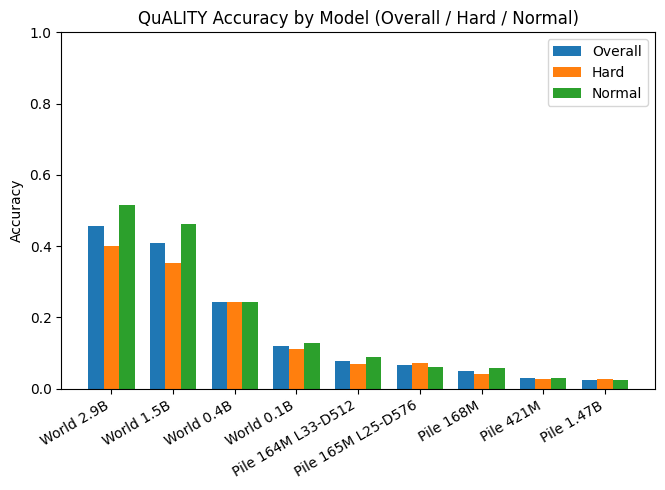

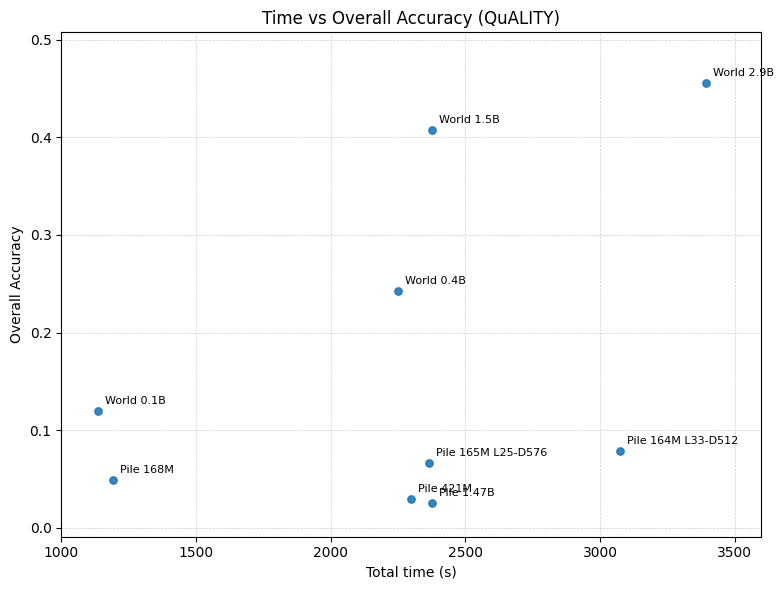

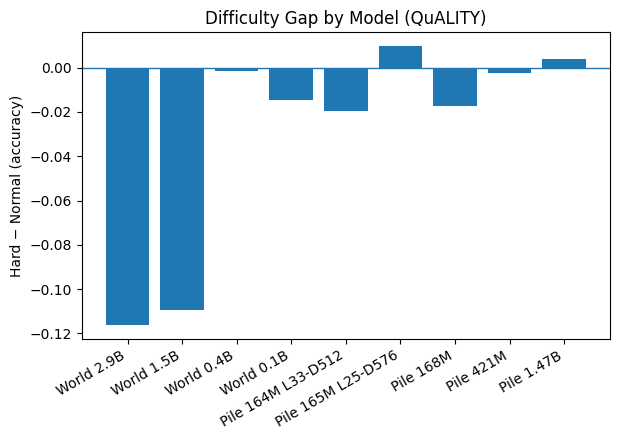

In [ ]:
# -*- coding: utf-8 -*-
# Visualize RACE results (matplotlib only, one chart per figure, no custom colors)
# This version reads from outputs/RACE_<split>_summary.json and writes figures into outputs/

import json
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------------
# Paths and basic configs
# -------------------------------------------------------------------

OUTPUTS_DIR = Path("outputs")
# Change this if you evaluated on a different split
EVAL_SPLIT = "validation"
JSON_PATH = OUTPUTS_DIR / f"RACE_{EVAL_SPLIT}_summary.json"
FIG_DIR = OUTPUTS_DIR  # save figures here as well


# -------------------------------------------------------------------
# IO helpers
# -------------------------------------------------------------------

def load_results(json_path: Path):
    """Load results from the RACE summary json produced by your script."""
    if not json_path.exists():
        raise FileNotFoundError(f"File not found: {json_path}")
    with json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, dict):
        raise ValueError("Expected a dict mapping model_name -> metrics dict.")
    return data


def to_rows(results_dict):
    """Convert dict to list of row dicts with safe defaults."""
    rows = []
    for model, metrics in results_dict.items():
        rows.append({
            "model": str(model),
            "total_time": float(metrics.get("Total time", float("nan"))),
            "overall": float(metrics.get("Overall Accuracy", float("nan"))),
            "high": float(metrics.get("High Accuracy", float("nan"))),
            "middle": float(metrics.get("Middle Accuracy", float("nan"))),
            "num_samples": float(metrics.get("Num samples", float("nan"))),
            "num_few_shots": float(metrics.get("Num few-shots", float("nan")))
                              if "Num few-shots" in metrics
                              else float("nan"),
        })
    return rows


def sort_rows(rows, key="overall", reverse=True):
    """Sort rows by a metric; NaNs go to the end."""
    valid = [r for r in rows if not math.isnan(r.get(key, float("nan")))]
    invalid = [r for r in rows if math.isnan(r.get(key, float("nan")))]
    valid_sorted = sorted(valid, key=lambda r: r[key], reverse=reverse)
    return valid_sorted + invalid


def ensure_outdir(path: Path):
    """Make sure the directory exists."""
    path.mkdir(parents=True, exist_ok=True)


# -------------------------------------------------------------------
# Plot helpers
# -------------------------------------------------------------------

def grouped_bar_accuracy(rows, outpath: Path):
    """Grouped bar chart: Overall / High / Middle accuracy per model."""
    models = [r["model"] for r in rows]
    overall = [r["overall"] for r in rows]
    high = [r["high"] for r in rows]
    middle = [r["middle"] for r in rows]

    x = range(len(models))
    width = 0.25

    plt.figure(figsize=(max(6, len(models) * 0.75), 5))
    plt.bar([i - width for i in x], overall, width, label="Overall")
    plt.bar(x, high, width, label="High")
    plt.bar([i + width for i in x], middle, width, label="Middle")

    plt.xticks(list(x), models, rotation=30, ha="right")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title(f"RACE Accuracy by Model (Overall / High / Middle) [{EVAL_SPLIT}]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


def scatter_time_vs_accuracy(rows, outpath: Path, top_k: int = 6):
    """Scatter: Total time (s) vs Overall accuracy.
    - Labels only top-K by accuracy + 4 extremes (min/max time, min/max accuracy).
    """
    xs, ys, labels = [], [], []
    for r in rows:
        if not math.isnan(r["total_time"]) and not math.isnan(r["overall"]):
            xs.append(r["total_time"])
            ys.append(r["overall"])
            labels.append(r["model"])

    if len(xs) == 0:
        raise ValueError("No valid points to plot.")

    plt.figure(figsize=(8, 6))
    plt.scatter(xs, ys, s=28, alpha=0.9)

    xs_np = np.array(xs)
    ys_np = np.array(ys)

    # extreme indices
    idx_min_time = int(np.argmin(xs_np))
    idx_max_time = int(np.argmax(xs_np))
    idx_min_acc = int(np.argmin(ys_np))
    idx_max_acc = int(np.argmax(ys_np))
    extreme_idx = {idx_min_time, idx_max_time, idx_min_acc, idx_max_acc}

    # top-K by accuracy
    k = min(top_k, len(ys_np))
    topk_idx = set(np.argsort(ys_np)[-k:].tolist())

    keep_idx = extreme_idx | topk_idx

    for i in sorted(keep_idx):
        plt.annotate(labels[i], (xs[i], ys[i]),
                     xytext=(5, 5),
                     textcoords="offset points",
                     fontsize=8)

    x_pad = (max(xs) - min(xs)) * 0.06 if max(xs) > min(xs) else 1.0
    y_pad = (max(ys) - min(ys)) * 0.08 if max(ys) > min(ys) else 0.05
    plt.xlim(min(xs) - x_pad, max(xs) + x_pad * 1.5)
    plt.ylim(min(ys) - y_pad, max(ys) + y_pad * 1.5)
    plt.margins(x=0.02, y=0.05)

    plt.xlabel("Total time (s)")
    plt.ylabel("Overall Accuracy")
    plt.title(f"Time vs Overall Accuracy (RACE, {EVAL_SPLIT})")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


def bar_difficulty_gap(rows, outpath: Path):
    """Bar: (High - Middle) accuracy per model."""
    models = [r["model"] for r in rows]
    gaps = []
    for r in rows:
        h, m = r["high"], r["middle"]
        gaps.append(float("nan") if (math.isnan(h) or math.isnan(m)) else (h - m))

    x = range(len(models))
    plt.figure(figsize=(max(6, len(models) * 0.7), 4.5))
    plt.bar(x, gaps)
    plt.axhline(0, linewidth=1)

    plt.xticks(list(x), models, rotation=30, ha="right")
    plt.ylabel("High − Middle (accuracy)")
    plt.title(f"Difficulty Gap by Model (RACE, {EVAL_SPLIT})")
    plt.tight.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


def bar_overall_accuracy(rows, outpath: Path):
    """Simple bar chart of overall accuracy (sorted by overall)."""
    models = [r["model"] for r in rows]
    overall = [r["overall"] for r in rows]

    x = range(len(models))
    plt.figure(figsize=(max(6, len(models) * 0.7), 4.5))
    plt.bar(x, overall)

    plt.xticks(list(x), models, rotation=30, ha="right")
    plt.ylabel("Overall Accuracy")
    plt.ylim(0, 1)
    plt.title(f"Overall Accuracy by Model (RACE, {EVAL_SPLIT})")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


def bar_time_per_sample(rows, outpath: Path):
    """Bar chart: average time per sample (Total time / Num samples)."""
    models = [r["model"] for r in rows]
    tps = []
    for r in rows:
        tt = r["total_time"]
        n = r["num_samples"]
        if math.isnan(tt) or math.isnan(n) or n <= 0:
            tps.append(float("nan"))
        else:
            tps.append(tt / n)

    x = range(len(models))
    plt.figure(figsize=(max(6, len(models) * 0.7), 4.5))
    plt.bar(x, tps)

    plt.xticks(list(x), models, rotation=30, ha="right")
    plt.ylabel("Time per sample (s)")
    plt.title(f"Average Time per Sample by Model (RACE, {EVAL_SPLIT})")
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    plt.close()


# -------------------------------------------------------------------
# Main
# -------------------------------------------------------------------

def main():
    ensure_outdir(OUTPUTS_DIR)
    results = load_results(JSON_PATH)
    rows = to_rows(results)

    # sort by overall accuracy (descending)
    rows_sorted = sort_rows(rows, key="overall", reverse=True)

    # 01: grouped accuracy (Overall / High / Middle)
    grouped_bar_accuracy(rows_sorted, FIG_DIR / f"RACE_{EVAL_SPLIT}_01_grouped_accuracy.png")

    # 02: time vs overall accuracy (scatter)
    scatter_time_vs_accuracy(rows_sorted, FIG_DIR / f"RACE_{EVAL_SPLIT}_02_time_vs_overall.png",
                             top_k=len(rows_sorted))

    # 03: difficulty gap (High - Middle)
    bar_difficulty_gap(rows_sorted, FIG_DIR / f"RACE_{EVAL_SPLIT}_03_high_middle_gap.png")

    # 04: sorted overall accuracy bar chart
    bar_overall_accuracy(rows_sorted, FIG_DIR / f"RACE_{EVAL_SPLIT}_04_overall_bar.png")

    # 05: average time per sample bar chart
    bar_time_per_sample(rows_sorted, FIG_DIR / f"RACE_{EVAL_SPLIT}_05_time_per_sample.png")


if __name__ == "__main__":
    main()
